In [1]:
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxx--------------Plotting Simulated SLSN Light Curves-----------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Modules
# ------------------------------------------------------------------------------------------------------------------- #
import os
import random
import pickle
import sncosmo
import simsurvey
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from astropy.cosmology import Planck15

import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator, FixedLocator
plt.style.use('bmh')

from RunSim_SLSN_Master import MagnetarSource, Load_ZTFData
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Initialize Globals
# ------------------------------------------------------------------------------------------------------------------- #
dict_bands = {'ztfg': [4087, 4722.7, 5522], 'ztfr': [5600, 6339.6, 7317], 'desi': [7317, 7886.1, 8884]}
dict_rlambda = {'ztfg': 3.694, 'ztfr': 2.425, 'desi': 1.718}
params_magnetar = ['P', 'B', 'Mej', 'Vej', 'kappa', 'kappa_gamma', 'Mns', 'Tf']

cm = cm.get_cmap('jet')

os.environ["HOME"] = "/home/avinash/Dropbox/ProjectGROWTH/codes/simsurvey"
DIR_HOME = os.environ.get("HOME")
DIR_INPUT = os.path.join(DIR_HOME, "data/")
DIR_PLOTS = os.path.join(DIR_HOME, "plots/")

# Name of the File containing the parameters for the Magnetar Model
file_param = os.path.join(DIR_INPUT, "Nicholl_Magnetar.dat")
file_paramflat = os.path.join(DIR_INPUT, "Nicholl_Magnetar_FlatV2.dat")

# Name of the File containing the Template Light Curve
file_template = os.path.join(DIR_INPUT, "PTF12dam.dat")

# Name of the File containing the probabilities of drawing a Magnetar Model
file_pdf = os.path.join(DIR_INPUT, "LF_0.2-0.4.dat")

# Name of the File containing the ZTF Observed Sample
file_sample = os.path.join(DIR_INPUT, "ZTFSampleV3.csv")

# Location of the Output Directory where the Pickle files are saved
DIR_OUTPUT = os.path.join(DIR_HOME, "output/")
# ------------------------------------------------------------------------------------------------------------------- #
# Location of the Plots Directory where the plots will be saved
DIR_PLOTS = os.path.join(DIR_HOME, "plots/")

if not os.path.exists(DIR_PLOTS):
    print("Plots Directory Doesn't Exist. Creating one...")
    os.makedirs(DIR_PLOTS)

os.chdir(DIR_PLOTS)
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Specify Pickle File To Read
# ------------------------------------------------------------------------------------------------------------------- #
prefix = 'LCS_Filtered_SLSN'
runmodel = 'Magnetar'
zrange = (0.20, 0.40)
rate = 5.00
iteration = 0

filename = "{0}_{1}_{2:.2f}_{3:.2f}_{4:.2f}_{5}.pkl".format(prefix, runmodel, zrange[0], zrange[1], rate, iteration)
print (filename)

data_mod = pickle.load(open(os.path.join(DIR_OUTPUT, filename), 'rb'))
lcs = simsurvey.LightcurveCollection(load=os.path.join(DIR_OUTPUT, filename))
print ("Number of Light Curves in Filtered Data: {0}".format(len(lcs.lcs)))

lcs.stats['absmag_max'] = {}
for band in dict_bands.keys():
    lcs.stats['absmag_max'][band] = np.full(len(data_mod['lcs']), np.nan)

# ------------------------------------------------------------------------------------------------------------------- #

LCS_Filtered_SLSN_Magnetar_0.20_0.40_5.00_0.pkl
Number of Light Curves in Filtered Data: 2152


### Loading the Magnetar Source Class + Magnetar Sample
1) Initialize Magnetar Model with Propagation Effects <br />
2) Load ZTF Filters <br />
3) Read the Sample of Magnetar Model Parameters from Nicholl et al. (2017) <br />
4) Read the Flat Sample of Magnetar Model Parameters from Nicholl et al. 2017 and Villar et al. (2018) <br/>
5) Estimate the Probability of Selection of the Models based on the Input Luminosity Function - 'LF_[Low/High].dat'

In [2]:
# ------------------------------------------------------------------------------------------------------------------- #
source = MagnetarSource()
dust = sncosmo.CCM89Dust()
pdf_df = pd.read_csv(file_pdf, sep='\s+')
mag_arr = pdf_df['mag'].values

bands = {'ztfg': 'ztfg_eff.txt', 'ztfr': 'ztfr_eff.txt', 'ztfi': 'ztfi_eff.txt'}

for band in bands.keys():                                                                             
    bpass = np.loadtxt(os.path.join(DIR_INPUT, bands[band]))                                         
    bandname = sncosmo.Bandpass(bpass[:, 0], bpass[:, 1], name=band)                                   
    sncosmo.registry.register(bandname, force=True)

try:
    prop_df = pd.read_csv(file_param, sep='\s+', comment='#')
    propflat_df = pd.read_csv(file_paramflat, sep='\s+', comment='#')
except OSError or FileNotFoundError:
    display_text("ERROR: File with Magnetar Parameters Missing. Using default parameters instead...")
    SLSN_param = {'P': [4.78, 2.93, 2.28, 0.98, 3.5],
                  'B': [2.03e14, 1.23e14, 1.8e13, 0.49e14, 1.56e14],
                  'Mej': [2.19, 4.54, 6.27, 33.71, 2.75],
                  'Vej': [5.12, 9.02, 7.01, 8.71, 8.38],
                  'kappa': [0.1, 0.16, 0.16, 0.19, 0.12],
                  'kappa_gamma': [0.06, 0.57, 0.01, 0.01, 0.04],
                  'Mns': [1.85, 1.83, 1.83, 1.8, 1.8],
                  'Tf': [6.58e3, 8e3, 6.48e3, 6.78e3, 5.07e3]}
else:
    SLSN_param = {}
    SLSN_paramflat = {}
    SLSN_prob = {}
    SLSN_probflat = {}

    for idx in range(prop_df.shape[0]):
        mag = mag_arr[np.abs(mag_arr - prop_df.loc[idx, 'M_g']).argmin()]
        SLSN_prob[idx] = pdf_df.loc[pdf_df['mag'] == mag, 'prob'].values[0]
    for idx in range(propflat_df.shape[0]):
        mag = mag_arr[np.abs(mag_arr - propflat_df.loc[idx, 'M_g']).argmin()]
        SLSN_probflat[idx] = pdf_df.loc[pdf_df['mag'] == mag, 'prob'].values[0]

    for name in params_magnetar:
        if name == 'B':
            SLSN_param[name] = 1e14 * prop_df[name].values
            SLSN_paramflat[name] = 1e14 * propflat_df[name].values

        elif name == 'Tf':
            SLSN_param[name] = 1e3 * prop_df[name].values
            SLSN_paramflat[name] = 1e3 * propflat_df[name].values
        else:
            SLSN_param[name] = prop_df[name].values
            SLSN_paramflat[name] = propflat_df[name].values

# ------------------------------------------------------------------------------------------------------------------- #

### Helper Functions

In [3]:
# ------------------------------------------------------------------------------------------------------------------- #

def z_to_distmod(z):
    distance = Planck15.luminosity_distance(z).value
    return 5 * np.log10(distance * 1e6) - 5


def display_text(text_to_display):
    """
    Displays text mentioned in the string 'text_to_display'
    Args:
        text_to_display : Text to be displayed
    Returns:
        None
    """
    print("# " + "-" * (12 + len(text_to_display)) + " #")
    print("# " + "-" * 5 + " " + str(text_to_display) + " " + "-" * 5 + " #")
    print("# " + "-" * (12 + len(text_to_display)) + " #\n")

# ------------------------------------------------------------------------------------------------------------------- #

### Functions For Plotting and Computing Light Curves

In [4]:
# ------------------------------------------------------------------------------------------------------------------- #

def modelparams(lc, data=data_mod):
    """
    Obtains the model parameters from the modified Pandas DataFrame 'data' containing all the Simulated
    light curves.
    Args:
        lc     : Index of the light curve for which the model parameters are to be obtained
        data   : Pandas DataFrame from which the model parameters will be read
    Returns:
        model  : Magnetar Source object containing the model parameters
    """
    model = sncosmo.Model(source=source, effects=[dust], effect_names=['host'], effect_frames=['rest'])
    for param in params_magnetar:
        model[param] = data['meta'][param][lc]

    return model


def calc_abslcparams(lc, runmodel='Magnetar'):
    """
    Computes the light curve in magnitude scale, signal-to-noise ratio and the extinction in the
    respective bands. It also computes the rest-frame phase and absolute magnitude light curve.
    Args:
        lc       : Index of the light curve whose parameters being calculated
        runmodel : Model being used as input [Choices: 'Magnetar', 'Template']
    Returns:
        lc_df    : Pandas DataFrame containing the original LC with the appended details
    """
    global data_mod, lcs
    
    def fill_max(snr5_df):
        for band, band_df in snr5_df.groupby('band'):
            data_mod['stats']['mag_max'][band][lc] = band_df['mag'].min()
            lcs.stats['mag_max'][band][lc] = band_df['mag'].min()
            lcs.stats['absmag_max'][band][lc] = band_df['absmag'].min()
        for band in dict_bands.keys():
            if band not in snr5_df['band'].values:
                data_mod['stats']['mag_max'][band][lc] = np.nan
                lcs.stats['mag_max'][band][lc] = np.nan
                lcs.stats['absmag_max'][band][lc] = np.nan

    lc_df = pd.DataFrame(data=data_mod['lcs'][lc], columns=data_mod['lcs'][lc].dtype.names)
    lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
    lc_df['magerr'] = (2.5 / np.log(10)) * (lc_df['fluxerr'] / lc_df['flux'])
    lc_df.loc[lc_df['flux'] < 0, 'magerr'] = np.nan
    
    lc_df['snr'] = lc_df['flux'] / lc_df['fluxerr']
    lc_df['phase'] = lc_df['time'] - data_mod['meta']['t0'][lc]
    lc_df['Alambda'] = lc_df['band'].apply(lambda band: data_mod['meta']['mwebv_sfd98'][lc] * dict_rlambda[band])
    
    zlc = data_mod['meta']['z'][lc]
    lc_df['restphase'] = lc_df['phase'] / (1 + zlc)

    if runmodel == 'Magnetar':
        model = modelparams(lc)
        lc_df['absmag'] = model.bandmag(lc_df['band'], 'ab', lc_df['restphase'])
        snr5_df = lc_df[lc_df['snr'] >= 5].copy()
        fill_max(snr5_df)

    elif runmodel == 'Template':
        distmag = 5 * np.log10(Planck15.luminosity_distance(zlc).value * 1e6) - 5
        corr = distmag - 2.5 * np.log10((1 + zlc))
        lc_df['absmag'] = lc_df['mag'] - corr - lc_df['Alambda']
        snr5_df = lc_df[lc_df['snr'] >= 5].copy()
        fill_max(snr5_df)

    else:
        print ("ERROR: Model Choice '{0}' is Invalid".format(runmodel))
        sys.exit(1)

    return lc_df


def set_plotparams(ax_obj, xticks=(50, 5), yticks=(1, 0.1), grid=True, fs=14):
    """
    Sets plot parameters to the axes object 'ax_obj'.
    Args:
        ax_obj      : Axes object to be used for plotting and setting plot parameters
        xticks      : X-Axis Major and Minor tick intervals
        yticks      : Y-Axis Major and Minor tick intervals
        grid        : Boolean stating whether to enable Grid in the plot
        fs          : Fontsize of the labels
    Returns:
    """
    if grid:
        ax_obj.grid(True, which='major', ls='--', lw=1)

    ax_obj.xaxis.set_ticks_position('both')
    ax_obj.yaxis.set_ticks_position('both')
    ax_obj.xaxis.set_major_locator(MultipleLocator(xticks[0]))
    ax_obj.xaxis.set_minor_locator(MultipleLocator(xticks[1]))
    ax_obj.yaxis.set_major_locator(MultipleLocator(yticks[0]))
    ax_obj.yaxis.set_minor_locator(MultipleLocator(yticks[1]))
    ax_obj.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, color='k',
                       labelcolor='k', labelsize=fs)
    ax_obj.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, color='k',
                       labelcolor='k', labelsize=fs)


def plot_sumabslcs(ax_obj, lc, runmodel='Magnetar', alpha=0.2, xlim=(-20, 370)):
    """
    Plots the Simulated Light Curves in a 2 x 3 Grid with 2 rows depicting the Apparent 
    and the Absolute Light Curves, respectively whereas the 3 columns depict the different 
    ZTF filters.
    Args:
        ax_obj   : Axes object to be used for plotting
        lc       : Index of the light curve whose parameters being calculated
        runmodel : Model being used as input [Choices: 'Magnetar', 'Template']
        alpha    : Transparency of the light curve to be plotted
        xlim     : X-Lims to be set for plotting
    Returns:
        snr3_df  : 3-sigma LC in a Pandas DataFrame with the appended details
    """
    def plot_subplot(ax_band, band):
        index, color = dict_vals[band]
        ax1 = ax_band[0][index]
        ax2 = ax_band[1][index]

        set_plotparams(ax1)
        set_plotparams(ax2)
        ax1.set_ylim(22.2, 15.6)
        ax2.set_ylim(-15.8, -23.2)
        ax1.set_xlim(xlim[0], xlim[1])
        ax2.set_xlim(xlim[0], xlim[1])
        ax1.set_title(band, color=color, fontsize=16)
        ax1.set_xlabel('Observed Phase [In Days]', fontsize=16)    
        ax2.set_xlabel('Rest-Frame Phase [In Days]', fontsize=16)    

        return ax1, ax2, color

    lc_df = calc_abslcparams(lc, runmodel=runmodel)
    snr3_df = lc_df[lc_df['snr'] >= 3].copy()
    dict_vals = {'ztfg': (0, 'g'), 'ztfr': (1, 'r'), 'desi': (2, 'blue')}

    list_bands = []
    for band, band_df in snr3_df.groupby('band'):
        list_bands.append(band)
        ax1, ax2, color = plot_subplot(ax_obj, band)

        ax1.errorbar(band_df['phase'], band_df['mag'], yerr=band_df['magerr'], ms=8, alpha=alpha,
                     ls='-', color='dimgrey', mfc=color, mew=0.5, marker='o', capthick=1, elinewidth=1,
                     capsize=2, zorder=1, label='_nolegend_')
        ax2.errorbar(band_df['restphase'], band_df['absmag'], yerr=band_df['magerr'], ms=8, alpha=alpha,
                     ls='', color='dimgrey', marker='o', mfc=color, mew=0.5, capthick=1, elinewidth=1,
                     capsize=2, zorder=1, label='_nolegend_')

    for band in dict_vals.keys():
        if band not in list_bands:
            plot_subplot(ax_obj, band)

    return snr3_df


def plot_applc(ax_obj, lc, runmodel='Magnetar', alpha=0.5, xlim=(-10, 370), data=data_mod, model=True):
    """
    Plots the Simulated Light Curves in Apparent Scale in a 1 x 3 Grid where the 3 columns depict
    the different ZTF filters.
    Args:
        ax_obj   : Axes object to be used for plotting
        lc       : Index of the light curve being plotted
        runmodel : Model being used as input [Choices: 'Magnetar', 'Template']
        alpha    : Transparency of the light curve to be plotted
        xlim     : X-Lims to be set for plotting
        data     : Master DataFrame from which light curves are being extracted
        model    : Boolean to plot the model light curve from which the data was drawn
    Returns:
        None
    """
    lc_df = calc_abslcparams(lc, runmodel=runmodel)
    dict_vals = {'ztfg': (0, 'g'), 'ztfr': (1, 'r'), 'desi': (2, 'blue')}
    
    def plot_subplot(ax_band, band):
        index, color = dict_vals[band]
        ax = ax_band[index]
        set_plotparams(ax, xticks=(50, 5), yticks=(0.5, 0.05), fs=15)
        ax.set_xlabel('Observed Phase [In Days]', fontsize=17)
        return ax, color

    list_bands = []
    for band, band_df in lc_df.groupby('band'):
        list_bands.append(band)
        index, color = dict_vals[band]
        ax, color = plot_subplot(ax_obj, band)

        reject_df = band_df[band_df['snr'] < 3].copy()
        lowsnr_df = band_df[(band_df['snr'] >= 3) & (band_df['snr'] < 5)].copy()
        highsnr_df = band_df[band_df['snr'] >= 5].copy()
        snr3_df = band_df[band_df['snr'] >= 3].copy()

        if snr3_df.shape[0] < 1:
            continue

        appmin = snr3_df['mag'].max()                     # 3-Sigma Minimum
        appmax = snr3_df['mag'].min()                     # 3-Sigma Maximum
        appmax5sig = data['stats']['mag_max'][band][lc]   # 5-Sigma Maximum
        
        ep_det = data['stats']['p_det'][lc]
        ep_last = data['stats']['p_last'][lc]
        ep_last3sig = snr3_df['phase'].max()
        ep_first3sig = snr3_df['phase'].min()
        corr = np.mean(snr3_df['mag'] - snr3_df['absmag'])
        
        if appmax5sig in snr3_df['mag'].values:
            ep_max5sig = snr3_df.loc[snr3_df['mag'] == appmax5sig, 'phase'].values[0]        
        else:
            ep_max5sig = np.nan

        ax.plot(reject_df['phase'], reject_df['mag'], ms=10, alpha=alpha, ls='', color=color,
                mfc='None', mew=2, marker='v', label='Below 3-Sigma')
        ax.errorbar(lowsnr_df['phase'], lowsnr_df['mag'], yerr=lowsnr_df['magerr'], ms=10,
                    alpha=alpha, ls='', lw=0.5, color=color, mfc='None', mew=2, marker='o',
                    capthick=1, elinewidth=1, capsize=2, label='3-Sigma')
        ax.errorbar(highsnr_df['phase'], highsnr_df['mag'], yerr=highsnr_df['magerr'], ms=10,
                    alpha=alpha, ls='-', lw=0.5, color='dimgrey', mfc=color, mew=1, marker='o',
                    capthick=1, elinewidth=1, capsize=2, label='5-Sigma')
        
        ax.axhline(appmax5sig, ls='-', lw=1, color='k')
        ax.axhline(appmin, ls='-', lw=1, color='k')
        ax.axvline(0, ls='-', lw=1.5, color='k')
        for epoch in [ep_det, ep_first3sig, ep_last3sig, ep_max5sig]:
            ax.axvline(epoch, ls='-', lw=1.5, color=color)
        
        if appmin - appmax5sig < 1.5:
            offset = 0.4
        else:
            offset = 0.6

        ax.set_xlim(xlim[0], ep_last3sig + 30)
        ax.set_ylim(appmin + offset + 0.3, appmax - offset)
        ax.fill_between((xlim[0], ep_last3sig + 30), appmin, appmax5sig, color=color, alpha=0.1)

        ax.text(ep_first3sig + 1, appmin + offset, 'First 3-Sigma Detection', fontsize=12, rotation=90)
        ax.text(ep_last3sig + 1, appmin + offset, 'Last 3-Sigma Detection', fontsize=12, rotation=90)
        ax.text(ep_det + 1, appmax + 0.4, '5-Sigma Detection', fontsize=12, rotation=90)
        if ep_max5sig != np.nan:
            ax.text(ep_max5sig + 1, appmax + 0.4, 'Maximum Epoch', fontsize=12, rotation=90)

        zlc = data_mod['meta']['z'][lc]
        ax.legend(markerscale=1.2, fontsize=11, fancybox=True, shadow=True, loc=1)
        ax.set_title(band + ' [{0}: z = {1:.2f}, Peak = {2:.2f} mag]'.format(lc, zlc, appmax5sig),
                     color=color, fontsize=16)
  
        ax_twin = ax.twinx()
        ax_twin.set_ylim(appmin + offset + 0.3, appmax - offset)
        ax_twin.set_yticklabels([round(float(tick) - corr, 1) for tick in ax.get_yticks()])
        ax_twin.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))
        ax_twin.yaxis.set_minor_locator(FixedLocator(ax.get_yticks(minor=True)))
        ax_twin.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, color='k', 
                           labelcolor='k', labelsize=15, pad=-50)
        ax_twin.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, color='k', 
                           labelcolor='k', labelsize=15)

        if model:
            if runmodel == 'Magnetar':
                model = modelparams(lc)
                phase_arr = np.arange(0, ep_last3sig, 1)
                mag = model.bandmag(band, 'ab', phase_arr)
                ax.plot(phase_arr * (1 + zlc), mag + corr, marker='', lw=3, ls='-', c=color, label='_nolegend_')
            else:
                print ("ERROR: Model Choice '{0}' is Invalid".format(runmodel))
                sys.exit(1)

    for band in dict_vals.keys():
        if band not in list_bands:
            plot_subplot(ax_obj, band)

        
def plot_abslc(ax_obj, lc, runmodel='Magnetar', alpha=0.5, xlim=(-10, 370), data=data_mod, model=True):
    """
    Plots the Simulated Light Curves in Absolute Scale in a 1 x 3 Grid where the 3 columns depict
    the different ZTF filters.
    Args:
        ax_obj   : Axes object to be used for plotting
        lc       : Index of the light curve being plotted
        runmodel : Model being used as input [Choices: 'Magnetar', 'Template']
        alpha    : Transparency of the light curve to be plotted
        xlim     : X-Lims to be set for plotting
        data     : Master DataFrame from which light curves are being extracted
        model    : Boolean to plot the model light curve from which the data was drawn
    Returns:
        None
    """
    lc_df = calc_abslcparams(lc, runmodel=runmodel)
    dict_vals = {'ztfg': (0, 'g'), 'ztfr': (1, 'r'), 'desi': (2, 'blue')}
    
    def plot_subplot(ax_band, band):
        index, color = dict_vals[band]
        ax = ax_band[index]
        set_plotparams(ax, xticks=(50, 5), yticks=(0.5, 0.05), fs=15)
        ax.set_xlabel('Rest Phase [In Days]', fontsize=17)
        return ax, color

    list_bands = []
    for band, band_df in lc_df.groupby('band'):
        list_bands.append(band)
        index, color = dict_vals[band]
        ax, color = plot_subplot(ax_obj, band)

        reject_df = band_df[band_df['snr'] < 3].copy()
        lowsnr_df = band_df[(band_df['snr'] >= 3) & (band_df['snr'] < 5)].copy()
        highsnr_df = band_df[band_df['snr'] >= 5].copy()
        snr3_df = band_df[band_df['snr'] >= 3].copy()

        if snr3_df.shape[0] < 1:
            continue

        zlc = data_mod['meta']['z'][lc]
        absmin = snr3_df['absmag'].max()                  # 3-Sigma Minimum
        absmax = snr3_df['absmag'].min()                  # 3-Sigma Maximum
        absmax5sig = lcs.stats['absmag_max'][band][lc]    # 5-Sigma Maximum

        ep_det = data['stats']['p_det'][lc] / (1 + zlc)
        ep_last = data['stats']['p_last'][lc] / (1 + zlc)
        ep_last3sig = snr3_df['restphase'].max()
        ep_first3sig = snr3_df['restphase'].min()

        if absmax5sig in snr3_df['absmag'].values:
            ep_max5sig = snr3_df.loc[snr3_df['absmag'] == absmax5sig, 'restphase'].values[0]        
        else:
            ep_max5sig = np.nan

        ax.plot(reject_df['restphase'], reject_df['absmag'], ms=11, alpha=alpha, ls='', color=color,
                mfc='None', mew=2, marker='v', label='Below 3-Sigma')
        ax.errorbar(lowsnr_df['restphase'], lowsnr_df['absmag'], yerr=lowsnr_df['magerr'], ms=11,
                    alpha=alpha, ls='', lw=0.5, color=color, mfc='None', mew=2, marker='o',
                    capthick=1, elinewidth=1, capsize=2, label='3-Sigma')
        ax.errorbar(highsnr_df['restphase'], highsnr_df['absmag'], yerr=highsnr_df['magerr'], ms=11,
                    alpha=alpha, ls='-', lw=0.5, color='dimgrey', mfc=color, mew=1, marker='o',
                    capthick=1, elinewidth=1, capsize=2, label='5-Sigma')
        
        ax.axhline(absmax5sig, ls='-', lw=1, color='k')
        ax.axhline(absmin, ls='-', lw=1, color='k')
        ax.axvline(0, ls='-', lw=1.5, color='k')
        for epoch in [ep_det, ep_first3sig, ep_last3sig, ep_max5sig]:
            ax.axvline(epoch, ls='-', lw=1.5, color=color)
        
        if absmin - absmax5sig < 2:
            offset = 0.4
        else:
            offset = 0.6

        ax.set_xlim(xlim[0], ep_last3sig + 30)
        ax.set_ylim(absmin + offset + 0.3, absmax - offset)
        ax.fill_between((xlim[0], ep_last3sig + 30), absmin, absmax5sig, color=color, alpha=0.1)

        ax.text(ep_first3sig + 1, absmin + offset, 'First 3-Sigma Detection', fontsize=12, rotation=90)
        ax.text(ep_last3sig + 1, absmin + offset, 'Last 3-Sigma Detection', fontsize=12, rotation=90)
        ax.text(ep_det + 1, absmax + 0.4, '5-Sigma Detection', fontsize=12, rotation=90)
        if ep_max5sig != np.nan:
            ax.text(ep_max5sig + 1, absmax + 0.4, 'Maximum Epoch', fontsize=12, rotation=90)

        ax.legend(markerscale=1.2, fontsize=11, fancybox=True, shadow=True, loc=1)
        ax.set_title(band + ' [{0}: z = {1:.2f}, Peak = {2:.2f} mag]'.format(lc, zlc, absmax5sig),
                     color=color, fontsize=16)

        if model:
            if runmodel == 'Magnetar':
                model = modelparams(lc)
                phase_arr = np.arange(0, ep_last3sig, 1)
                mag = model.bandmag(band, 'ab', phase_arr)
                ax.plot(phase_arr, mag, marker='', lw=3, ls='-', c=color, label='_nolegend_')
            else:
                print ("ERROR: Model Choice '{0}' is Invalid".format(runmodel))
                sys.exit(1)

    for band in dict_vals.keys():
        if band not in list_bands:
            plot_subplot(ax_obj, band)

# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Distribution of Peak 'ztfg' Absolute Magnitudes of the Input

Size of the ZTF Sample with z < 0.4 = 42
Size of the observed ZTF Sample with 0.2 < z <= 0.4 and g/r peak <= 19.5 mag = 19


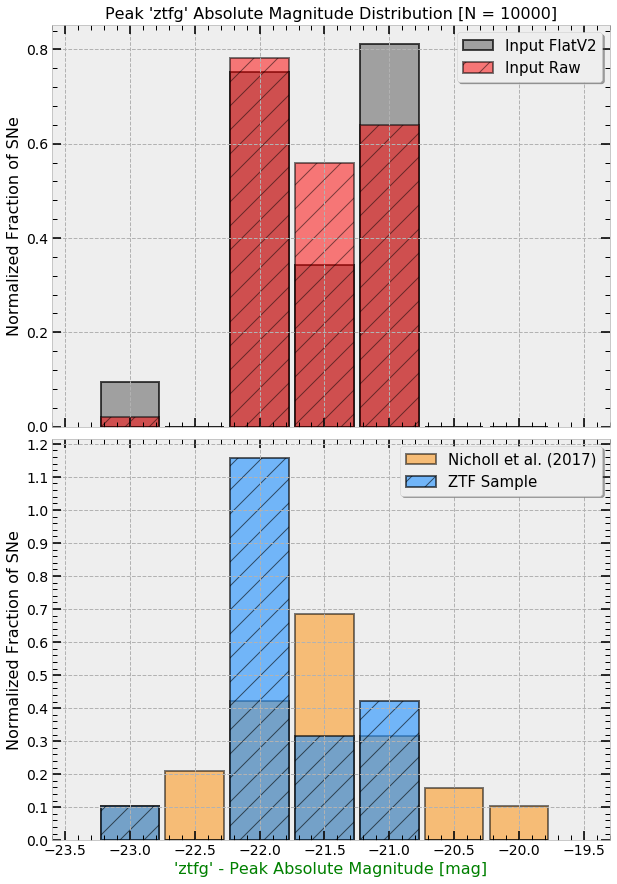

In [5]:
# ------------------------------------------------------------------------------------------------------------------- #
fig0, (ax01, ax02) = plt.subplots(2, 1, sharex=True, figsize=(10, 15))

# Read ZTF Observed Sample Data
ztf_df = pd.read_csv(file_sample, comment='#')
print ("Size of the ZTF Sample with z < 0.4 = {0}".format(ztf_df.shape[0]))
ztf_df = ztf_df[(ztf_df['redshift'] > 0.2) & (ztf_df['redshift'] <= 0.4)]
ztf_df = ztf_df[(ztf_df['gpeak'] <= 19.5) | (ztf_df['rpeak'] <= 19.5)]
print ("Size of the observed ZTF Sample with 0.2 < z <= 0.4 and g/r peak <= 19.5 mag = {0}".format(ztf_df.shape[0]))

ztfabsg = ztf_df['gpeak_abs'].values
ztfappg = ztf_df['gp_nc'].values
ztfappr = ztf_df['rp_nc'].values
ztfz = ztf_df['redshift'].values

# Read Indexes of Input Magnetar Model
# idxdata = pd.read_csv(os.path.join(DIR_HOME, 'notebooks/LogSim_Indexes.dat'), sep='\s+', names=['run', 'idx'])
# idxdata = idxdata.set_index('run')
# idxsampleflat = [propflat_df.loc[i, 'M_g'] for i in idxdata['idx'].values]

# Input Sample Distribution [Normal + Flat]
iterations = 10000
idx = random.choices(population=list(SLSN_prob.keys()), weights=list(SLSN_prob.values()), k=iterations)
idxflat = random.choices(population=list(SLSN_probflat.keys()), weights=list(SLSN_probflat.values()), k=iterations) 
itersample = [prop_df.loc[i, 'M_g'] for i in idx]
itersampleflat = [propflat_df.loc[i, 'M_g'] for i in idxflat]

h_absmg, b_absmg = np.histogram(prop_df['M_g'], range=(-23.25, -19.75), density=True, bins=7)
h_ztf, b_ztf = np.histogram(ztfabsg, range=(-23.25, -19.75), density=True, bins=7)
h_iter, b_iter = np.histogram(itersample, range=(-23.25, -19.75), density=True, bins=7)
h_iterf, b_iterf = np.histogram(itersampleflat, range=(-23.25, -19.75), density=True, bins=7)
c_absmg = (b_absmg[:-1] + b_absmg[1:]) / 2
c_ztf = (b_ztf[:-1] + b_ztf[1:]) / 2
c_iter = (b_iter[:-1] + b_iter[1:]) / 2
c_iterf = (b_iterf[:-1] + b_iterf[1:]) / 2

# h_idx, b_idx = np.histogram(idxflat, range=(-23.25, -19.75), density=True, bins=7)
# c_idx = (b_idx[:-1] + b_idx[1:]) / 2

# ax01.bar(c_idx, h_idx, width=0.5, color='dodgerblue', ec='k', lw=3, alpha=0.5,
#          hatch='\ ', label='Input Distribution - InsideCode')
ax01.bar(c_iterf, h_iterf, width=0.45, color='grey', ec='k', alpha=0.7, lw=2, hatch='',label='Input FlatV2')
ax01.bar(c_iter, h_iter, width=0.45, color='r', ec='k', alpha=0.5, lw=2, hatch='/',label='Input Raw')
ax02.bar(c_absmg, h_absmg, width=0.45, color='darkorange', ec='k', lw=2, alpha=0.5, label='Nicholl et al. (2017)')
ax02.bar(c_ztf, h_ztf, width=0.45, color='dodgerblue', ec='k', hatch='/', alpha=0.6, lw=2, label='ZTF Sample')

ax01.set_xlim(-23.6, -19.3)
ax01.legend(fontsize=15, fancybox=True, shadow=True)
ax02.legend(fontsize=15, fancybox=True, shadow=True)
set_plotparams(ax01, xticks=(0.5, 0.1), yticks=(0.2, 0.04), fs=14)
set_plotparams(ax02, xticks=(0.5, 0.1), yticks=(0.1, 0.02), fs=14)
ax01.set_ylabel("Normalized Fraction of SNe", fontsize=16)
ax02.set_ylabel("Normalized Fraction of SNe", fontsize=16)
ax02.set_xlabel("'ztfg' - Peak Absolute Magnitude [mag]", color='g', fontsize=16)
ax01.set_title("Peak 'ztfg' Absolute Magnitude Distribution [N = {0}]".format(iterations), fontsize=16)

fig0.subplots_adjust(hspace=0.03)
fig0.savefig("PLOT_InputSelectionDistribution_{0}_{1}.pdf".format(zrange[0], zrange[1]), format='pdf', dpi=2000,
             bbox_inches='tight')
plt.show()
plt.close(fig0)
# ------------------------------------------------------------------------------------------------------------------- #


### PLOT - Summation of Simulated Light Curves

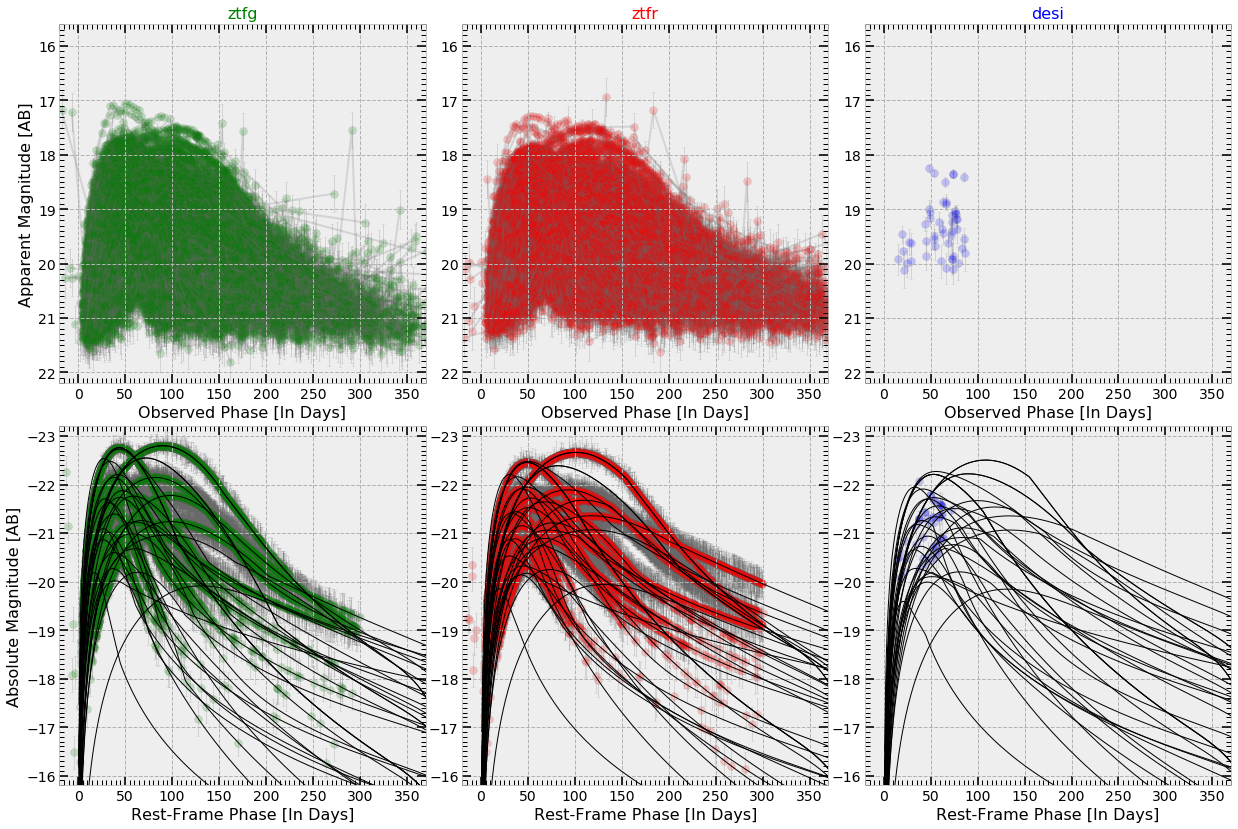

In [6]:
# ------------------------------------------------------------------------------------------------------------------- #
fig, ax = plt.subplots(2, 3, figsize=(21, 14))

for lc in range(len(data_mod['lcs'])):
    plot_sumabslcs(ax, lc)

if runmodel == 'Template':
    ptf12 = pd.read_csv(file_template, sep='\s+', comment='#')
    distmag = z_to_distmod(0.107)
    
    ax[0][0].plot(ptf12['Phase'], ptf12['M_g'] + distmag, marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
    ax[0][1].plot(ptf12['Phase'], ptf12['M_r'] + distmag, marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
    ax[0][2].plot(ptf12['Phase'], ptf12['M_i'] + distmag, marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
    ax[1][0].plot(ptf12['Phase'], ptf12['M_g'], marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
    ax[1][1].plot(ptf12['Phase'], ptf12['M_r'], marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')
    ax[1][2].plot(ptf12['Phase'], ptf12['M_i'], marker='', lw=5, ls='-', c='k', zorder=2, label='PTF12dam')

elif runmodel == 'Magnetar':
    for idx in range(len(SLSN_paramflat['P'])):
#     for idx in set(idxflat):
        model = sncosmo.Model(source=source, effects=[dust], effect_names=['host'], effect_frames=['rest'])
        for (param, val) in SLSN_paramflat.items():
            model[param] = val[idx]
            
        phase_arr = np.arange(0, 400, 1)
        gmag = model.bandmag('ztfg', 'ab', phase_arr)
        rmag = model.bandmag('ztfr', 'ab', phase_arr)
        imag = model.bandmag('desi', 'ab', phase_arr)
        
        ax[1][0].plot(phase_arr, gmag, marker='', lw=1, ls='-', c='k', zorder=2, label='_nolegend_')
        ax[1][1].plot(phase_arr, rmag, marker='', lw=1, ls='-', c='k', zorder=2, label='_nolegend_')
        ax[1][2].plot(phase_arr, imag, marker='', lw=1, ls='-', c='k', zorder=2, label='_nolegend_')
else:
    print ("ERROR: Model Choice '{0}' is Invalid".format(runmodel))
    sys.exit(1)

ax[0][0].set_ylabel("Apparent Magnitude [AB]", fontsize=16)
ax[1][0].set_ylabel("Absolute Magnitude [AB]", fontsize=16)

fig.subplots_adjust(hspace=0.12, wspace=0.10)
fig.savefig("PLOT_LCS_{0}_{1}_{2}_{3}_{4}.pdf".format(runmodel, zrange[0], zrange[1], rate, iteration),
            format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Individual Simulated Light Curve [Apparent/Absolute] [Specify Index]

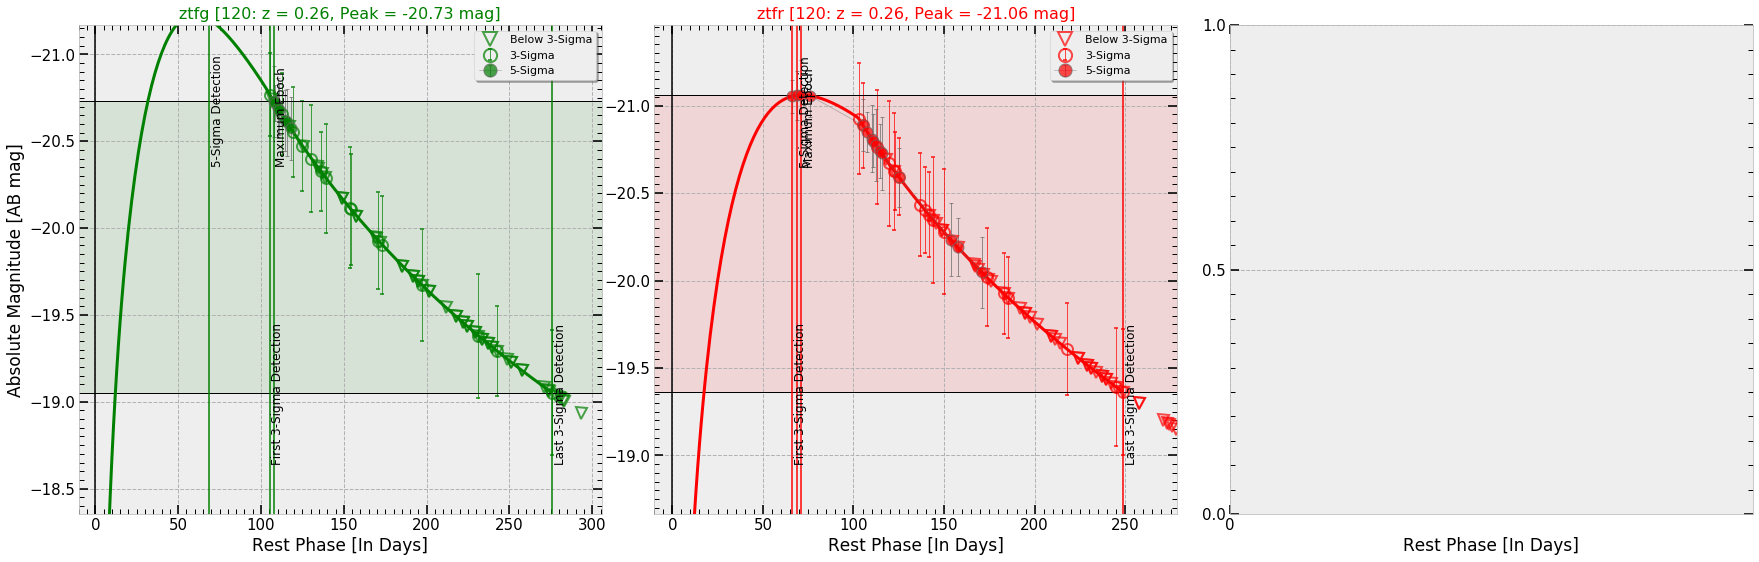

In [7]:
# ------------------------------------------------------------------------------------------------------------------- #
lc = 120

# for idx in range(len(lcs.lcs)):
for idx in range(lc, lc + 1, 1):
    fig2, ax2 = plt.subplots(1, 3, figsize=(30, 9))
    fig2.subplots_adjust(wspace=0.1)

#     plot_applc(ax2, idx, alpha=0.7, model=True)    
#     ax2[0].set_ylabel("Apparent Magnitude [AB mag]", fontsize=17)
#     fig2.savefig('TestApp.pdf', format='pdf', dpi=2000, bbox_inches='tight')

    plot_abslc(ax2, idx, alpha=0.7, model=True)
    ax2[0].set_ylabel("Absolute Magnitude [AB mag]", fontsize=17)
#     fig2.savefig('TestAbs.pdf', format='pdf', dpi=2000, bbox_inches='tight')

    fig2.savefig('PLOT_LC-{0}_{1}_{2}_{3}_{4}_{5}.pdf'.format(idx, runmodel, zrange[0], zrange[1], rate, iteration),
                 format='pdf', dpi=2000, bbox_inches='tight')
    plt.show()
    plt.close(fig2)
    
    # magerr = 1.0857/SNR = (2.5 / ln(10)) * (ferr/f)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Detection Phase Distribution of Simulated Light Curves

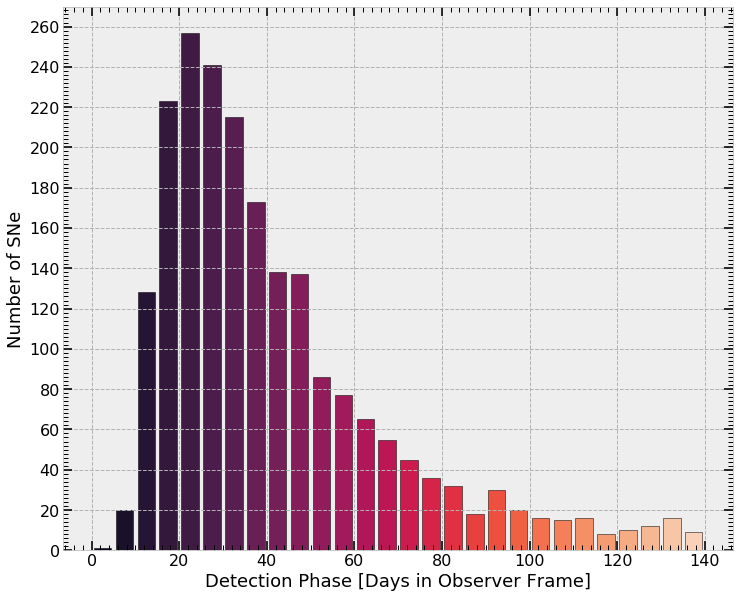

In [8]:
# ------------------------------------------------------------------------------------------------------------------- #
fig3 = plt.figure(figsize=(12, 10))
ax3 = fig3.add_subplot(111)

heights, bins = np.histogram(lcs.stats['p_det'], range=(0, 140), bins=28)
centers = (bins[:-1] + bins[1:]) / 2
ax3.bar(centers, heights, width=4, ec='k', lw=0.5, color=sns.color_palette('rocket', len(bins)))

set_plotparams(ax3, xticks=(20, 2), yticks=(20, 2), fs=16)
ax3.set_xlabel("Detection Phase [Days in Observer Frame]", fontsize=18)
ax3.set_ylabel("Number of SNe", fontsize=18)

fig3.savefig("PLOT_DPD_{0}_{1}_{2}_{3}_{4}.pdf".format(runmodel, zrange[0], zrange[1], rate, iteration),
             format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig3)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Redshift Distribution of Simulated Light Curves

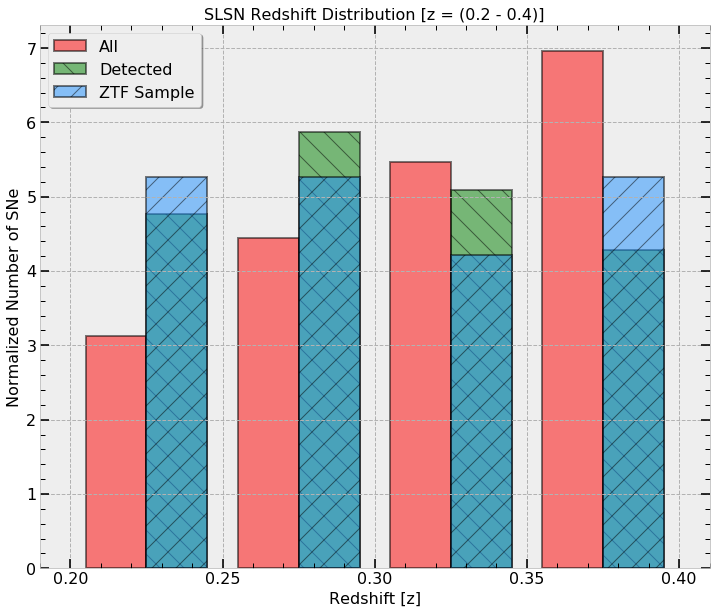

In [9]:
# ------------------------------------------------------------------------------------------------------------------- #
fig4 = plt.figure(figsize=(12, 10))
ax4 = fig4.add_subplot(111)

zh_full, zb_full = np.histogram(lcs.meta_full['z'], range=(0.2, 0.4), density=True, bins=4)
zh, zb = np.histogram(lcs.meta['z'], range=(0.2, 0.4), density=True, bins=4)
zh_ztf, zb_ztf = np.histogram(ztfz, range=(0.2, 0.4), density=True, bins=4)
zc_full = (zb_full[:-1] + zb_full[1:]) / 2
zc = (zb[:-1] + zb[1:]) / 2
zc_ztf = (zb_ztf[:-1] + zb_ztf[1:]) / 2

ax4.bar(zc_full - 0.01, zh_full, width=0.02, alpha=0.5, ec='k', lw=2, color='r', label='All')
ax4.bar(zc + 0.01, zh, width=0.02, alpha=0.5, ec='k', lw=2, color='g', hatch='\ ', label='Detected')
ax4.bar(zc_ztf + 0.01, zh_ztf, width=0.02, alpha=0.5, ec='k', lw=2, color='dodgerblue',
        hatch='/', label='ZTF Sample')

ax4.set_xlim(0.19, 0.41)
ax4.legend(fontsize=16, loc=2, fancybox=True, shadow=True)
set_plotparams(ax4, xticks=(0.05, 0.01), yticks=(1, 0.2), fs=16)
ax4.set_xlabel("Redshift [z]", fontsize=16)
ax4.set_ylabel("Normalized Number of SNe", fontsize=16)
ax4.set_title("SLSN Redshift Distribution [z = ({0} - {1})]".format(zrange[0], zrange[1]), fontsize=16)

# ax4.axvline(zrange[0], ls='-', lw=2, c='k')
# ax4.axvline(zrange[1], ls='-', lw=2, c='k')
# ax4.text((zrange[0] + zrange[1]) / 2.5, 0.9 * ax4.get_ylim()[1], s='Simulation Regime', color='k', fontsize=18)
# ax4.fill_betweenx(ax4.get_ylim(), zrange[0], zrange[1], color='tomato', alpha=0.15)
# axins = ax4.inset_axes([0.08, 0.47, 0.53, 0.55])
# ax4.indicate_inset_zoom(axins)
# axins.bar(zcentersfull - 0.005, zhsfull, width=0.01, alpha=0.9, color='orangered', label='All')
# axins.bar(zcenters + 0.005, zhs, width=0.01, alpha=0.9, ec='k', lw=0.8, color='navy', label='Detected')
# axins.set_xlim(-0.02, 0.45)
# axins.set_ylim(0, 110)
# set_plotparams(axins, xticks=(0.1, 0.01), yticks=(20, 2), fs=16)

fig4.savefig("PLOT_RD_{0}_{1}_{2}_{3}_{4}.pdf".format(runmodel, zrange[0], zrange[1], rate, iteration),
             format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig4)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Peak Apparent Magnitude Distribution of Simulated Light Curves

18.971084210526314 18.97368421052632
18.99796826213585 19.00118539592224


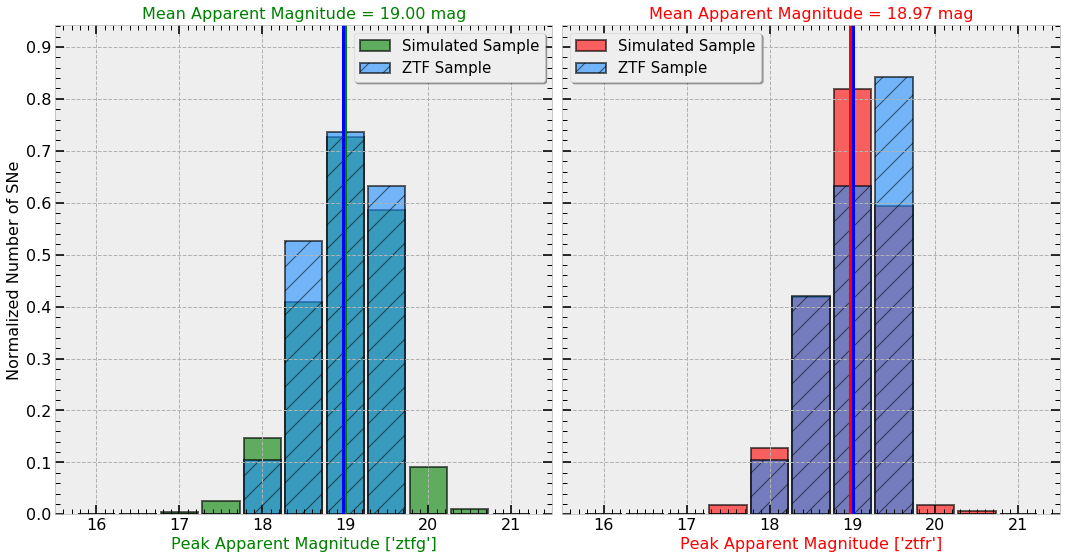

In [10]:
# ------------------------------------------------------------------------------------------------------------------- #
def arr_stats(arr):
    return np.mean(arr), np.std(arr)

fig5, (ax51, ax52) = plt.subplots(1, 2, sharey=True, figsize=(18, 9))

simappg = lcs.stats['mag_max']['ztfg']; simappg = simappg[~np.isnan(simappg)]
simappr = lcs.stats['mag_max']['ztfr']; simappr = simappr[~np.isnan(simappr)]
hsim_g, bsim_g = np.histogram(simappg, range=(15.75, 21.25), density=True, bins=11)
hsim_r, bsim_r = np.histogram(simappr, range=(15.75, 21.25), density=True, bins=11)
happ_g, bapp_g = np.histogram(ztfappg, range=(15.75, 21.25), density=True, bins=11)
happ_r, bapp_r = np.histogram(ztfappr, range=(15.75, 21.25), density=True, bins=11)
csim_g = (bsim_g[:-1] + bsim_g[1:]) / 2
csim_r = (bsim_r[:-1] + bsim_r[1:]) / 2
capp_g = (bapp_g[:-1] + bapp_g[1:]) / 2
capp_r = (bapp_r[:-1] + bapp_r[1:]) / 2

# ax51.bar(csim_g, hsim_g, width=0.4, ec='k', lw=0.5, color=sns.color_palette('rocket', len(b_g)))
# ax52.bar(csim_r, hsim_r, width=0.4, ec='k', lw=0.5, color=sns.color_palette('rocket', len(b_r)))
ax51.bar(csim_g, hsim_g, width=0.45, ec='k', lw=2, alpha=0.6, color='g', label='Simulated Sample')
ax52.bar(csim_r, hsim_r, width=0.45, ec='k', lw=2, alpha=0.6, color='r', label='Simulated Sample')
ax51.bar(capp_g, happ_g, width=0.45, ec='k', lw=2, alpha=0.6, hatch='/', color='dodgerblue', label='ZTF Sample')
ax52.bar(capp_r, happ_r, width=0.45, ec='k', lw=2, alpha=0.6, hatch='/', color='dodgerblue', label='ZTF Sample')

meansim_g, stdsim_g = arr_stats(simappg)
meansim_r, stdsim_r = arr_stats(simappr)
meanapp_g, stdapp_g = arr_stats(ztfappg)
meanapp_r, stdapp_r = arr_stats(ztfappr)

print (meanapp_g, np.average(capp_g, weights=happ_g))
print (meansim_g, np.average(csim_g, weights=hsim_g))

# meansim_g = np.average(csim_g, weights=hsim_g)
# meansim_r = np.average(csim_r, weights=hsim_r)
# stdsim_g = np.sqrt(np.average((csim_g - meansim_g) ** 2, weights=hsim_g))
# stdsim_r = np.sqrt(np.average((csim_r - meansim_r) ** 2, weights=hsim_r))
# meanapp_g = np.average(capp_g, weights=happ_g)
# meanapp_r = np.average(capp_r, weights=happ_r)
# stdapp_g = np.sqrt(np.average((capp_g - meanapp_g) ** 2, weights=happ_g))
# stdapp_r = np.sqrt(np.average((capp_r - meanapp_r) ** 2, weights=happ_r))
# import scipy.stats as stats
# xarr = np.arange(15.5, 21.5, 0.1)
# gauss_g = stats.norm.pdf(xarr, meansim_g, stdsim_g)
# gauss_r = stats.norm.pdf(xarr, meansim_r, stdsim_r)
# ax51.fill_between(xarr, gauss_g * np.sum(hsim_g), color='g')
# ax52.fill_between(xarr, gauss_r * np.sum(hsim_r), color='r')

ax51.axvline(meansim_g, ls='-', lw=3, color='g')
ax52.axvline(meansim_r, ls='-', lw=3, color='r')
ax51.axvline(meanapp_g, ls='-', lw=3, color='blue')
ax52.axvline(meanapp_r, ls='-', lw=3, color='blue')

# ax51.set_xlim(15.6, 21.2)
# ax52.set_xlim(15.6, 21.2)
ax51.set_ylim(0, max(np.max(hsim_g), np.max(happ_g)) + 0.1)
ax52.set_ylim(0, max(np.max(hsim_r), np.max(happ_r)) + 0.1)

ax51.legend(fontsize=15, fancybox=True, shadow=True)
ax52.legend(fontsize=15, fancybox=True, shadow=True)
set_plotparams(ax51, xticks=(1, 0.1), yticks=(0.1, 0.02), fs=16)
set_plotparams(ax52, xticks=(1, 0.1), yticks=(0.1, 0.02), fs=16)
ax51.set_ylabel("Normalized Number of SNe", fontsize=16)
ax51.set_xlabel("Peak Apparent Magnitude ['ztfg']", color='g', fontsize=16)
ax52.set_xlabel("Peak Apparent Magnitude ['ztfr']", color='r', fontsize=16)
ax51.set_title("Mean Apparent Magnitude = {0:.2f} mag".format(meansim_g), color='g', fontsize=16)
ax52.set_title("Mean Apparent Magnitude = {0:.2f} mag".format(meansim_r), color='r', fontsize=16)

fig5.subplots_adjust(wspace=0.02)
fig5.savefig("PLOT_AppMD_{0}_{1}_{2}_{3}_{4}.pdf".format(runmodel, zrange[0], zrange[1], rate, iteration),
             format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig5)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Peak Absolute Magnitude Distribution of Simulated Light Curves

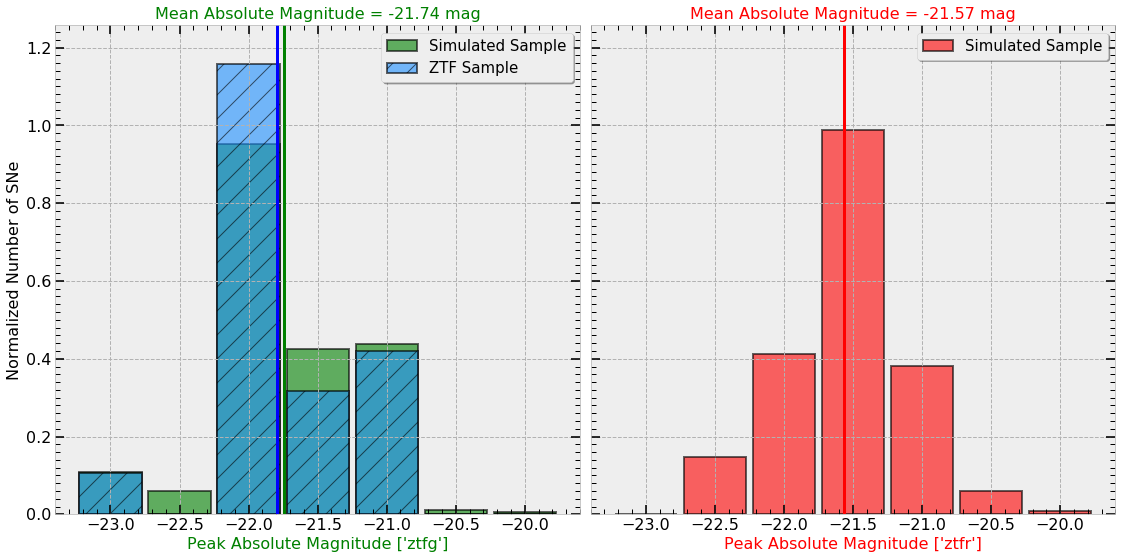

In [24]:
# ------------------------------------------------------------------------------------------------------------------- #
fig5, (ax51, ax52) = plt.subplots(1, 2, sharey=True, figsize=(19, 9))

simabsg = lcs.stats['absmag_max']['ztfg']; simabsg = simabsg[~np.isnan(simabsg)]
simabsr = lcs.stats['absmag_max']['ztfr']; simabsr = simabsr[~np.isnan(simabsr)]
hsim_g, bsim_g = np.histogram(simabsg, range=(-23.25, -19.75), density=True, bins=7)
hsim_r, bsim_r = np.histogram(simabsr, range=(-23.25, -19.75), density=True, bins=7)
habs_g, babs_g = np.histogram(ztfabsg, range=(-23.25, -19.75), density=True, bins=7)

csim_g = (bsim_g[:-1] + bsim_g[1:]) / 2
csim_r = (bsim_r[:-1] + bsim_r[1:]) / 2
cabs_g = (babs_g[:-1] + babs_g[1:]) / 2

ax51.bar(csim_g, hsim_g, width=0.45, ec='k', lw=2, alpha=0.6, color='g', label='Simulated Sample')
ax52.bar(csim_r, hsim_r, width=0.45, ec='k', lw=2, alpha=0.6, color='r', label='Simulated Sample')
ax51.bar(cabs_g, habs_g, width=0.45, color='dodgerblue', ec='k', alpha=0.6, lw=2, hatch='/', label='ZTF Sample')
# ax51.bar(c_iterf, h_iterf, width=0.45, color='grey', ec='k', alpha=0.5, lw=2,
#          hatch='\ ', label='Input Distribution Flat')

meansim_g, stdsim_g = arr_stats(simabsg)
meansim_r, stdsim_r = arr_stats(simabsr)
meanabs_g, stdabs_g = arr_stats(ztfabsg)

# mean_g = np.average(c_g, weights=h_g)
# mean_r = np.average(c_r, weights=h_r)
# std_g = np.sqrt(np.average((c_g - mean_g) ** 2, weights=h_g))
# std_r = np.sqrt(np.average((c_r - mean_r) ** 2, weights=h_r))
# meanabs_g = np.average(cabs_g, weights=habs_g)
# meanabs_r = np.average(cabs_r, weights=habs_r)
# stdabs_g = np.sqrt(np.average((cabs_g - meanabs_g) ** 2, weights=habs_g))
# stdabs_r = np.sqrt(np.average((cabs_r - meanabs_r) ** 2, weights=habs_r))
# import scipy.stats as stats
# xarr = np.arange(-23.5, -19.5, 0.1)
# gauss_g = stats.norm.pdf(xarr, meansim_g, stdsim_g)
# gauss_r = stats.norm.pdf(xarr, meansim_r, stdsim_r)
# ax51.fill_between(xarr, gauss_g * np.sum(hsim_g), color='g')
# ax52.fill_between(xarr, gauss_r * np.sum(hsim_r), color='r')

ax51.axvline(meansim_g, ls='-', lw=3, color='g')
ax52.axvline(meansim_r, ls='-', lw=3, color='r')
ax51.axvline(meanabs_g, ls='-', lw=3, color='blue')
# ax52.axvline(meanabs_r, ls='-', lw=3, color='g')

ax51.set_xlim(-23.4, -19.6)
ax52.set_xlim(-23.4, -19.6)
ax51.set_ylim(0, max(np.max(hsim_g), np.max(habs_g), np.max(hsim_r)) + 0.1)
ax51.legend(fontsize=15, fancybox=True, shadow=True)
ax52.legend(fontsize=15, fancybox=True, shadow=True)

set_plotparams(ax51, xticks=(0.5, 0.1), yticks=(0.2, 0.02), fs=16)
set_plotparams(ax52, xticks=(0.5, 0.1), yticks=(0.2, 0.02), fs=16)
ax51.set_ylabel("Normalized Number of SNe", fontsize=16)
ax51.set_xlabel("Peak Absolute Magnitude ['ztfg']", color='g', fontsize=16)
ax52.set_xlabel("Peak Absolute Magnitude ['ztfr']", color='r', fontsize=16)
ax51.set_title("Mean Absolute Magnitude = {0:.2f} mag".format(meansim_g), color='g', fontsize=16)
ax52.set_title("Mean Absolute Magnitude = {0:.2f} mag".format(meansim_r), color='r', fontsize=16)

fig5.subplots_adjust(wspace=0.02)
fig5.savefig("PLOT_AbsMD_{0}_{1}_{2}_{3}_{4}.pdf".format(runmodel, zrange[0], zrange[1], rate, iteration),
             format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig5)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Cumulative Distribution of 'ztfg' Peak Absolute Magnitudes

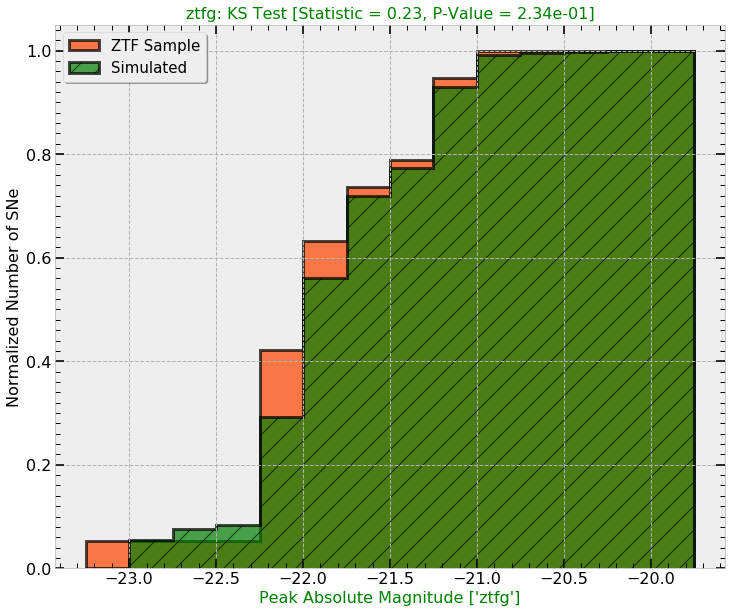

In [32]:
# ------------------------------------------------------------------------------------------------------------------- #
# Calculate KS-Test Statistic and P-Value
ksval = ks_2samp(simabsg, ztfabsg)

fig5, ax5 = plt.subplots(1, 1, figsize=(12, 10))

ax5.hist(ztfabsg, ls='-', ec='k', lw=3, color='orangered', range=(-23.25, -19.75), bins=14, 
         histtype='step', cumulative=True, density=True, fill=True, alpha=0.7, label='ZTF Sample',)
ax5.hist(simabsg, ls='-', ec='k', lw=3, color='g', hatch='/', range=(-23.25,-19.75), bins=14,
         histtype='step', cumulative=True, density=True, fill=True, alpha=0.7, label='Simulated')

ax5.legend(fontsize=15, fancybox=True, shadow=True, loc=2)
set_plotparams(ax5, xticks=(0.5, 0.1), yticks=(0.2, 0.02), fs=16)
ax5.set_xlabel("Peak Absolute Magnitude ['ztfg']", color='g', fontsize=16)
ax5.set_ylabel("Normalized Number of SNe", fontsize=16)
ax5.set_title("{0}: KS Test [Statistic = {1:.2f}, P-Value = {2:.2e}]".format('ztfg', ksval.statistic, ksval.pvalue),
              color='g', fontsize=16)

fig5.savefig("PLOT_AbsKSTest_{0}_{1}_{2}_{3}_{4}.pdf".format(runmodel, zrange[0], zrange[1], rate, iteration),
             format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig5)
# ------------------------------------------------------------------------------------------------------------------- #

### Compute Peak Abs Mag and Rise Time of Models from Nicholl et al. (2017)

In [13]:
# # ------------------------------------------------------------------------------------------------------------------- #
# dict_peakabsmag = {'ztfg': [], 'ztfr': [], 'desi': []}
# dict_risetime = {'ztfg': [], 'ztfr': [], 'desi': []}

# for idx in range(len(SLSN_param['P'])):
#     model = sncosmo.Model(source=source, effects=[dust], effect_names=['host'], effect_frames=['rest'])
#     for (param, val) in SLSN_param.items():
#         model[param] = val[idx]

#     phase_arr = np.arange(1, 200, 0.5)
#     gmag = model.bandmag('ztfg', 'ab', phase_arr)
#     rmag = model.bandmag('ztfr', 'ab', phase_arr)
#     imag = model.bandmag('desi', 'ab', phase_arr)
    
#     gmax = gmag.min()
#     rmax = rmag.min()
#     imax = imag.min()
    
#     grise = phase_arr[np.where(gmag == gmax)]
#     rrise = phase_arr[np.where(rmag == rmax)]
#     irise = phase_arr[np.where(imag == imax)]

#     dict_peakabsmag['ztfg'].append(gmax)
#     dict_peakabsmag['ztfr'].append(rmax)
#     dict_peakabsmag['desi'].append(imax)

#     dict_risetime['ztfg'].append(grise[0])
#     dict_risetime['ztfr'].append(rrise[0])
#     dict_risetime['desi'].append(irise[0])
    
# # ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Rise Time Distribution of the Magnetar Model

In [14]:
# # ------------------------------------------------------------------------------------------------------------------- #
# fig6, (ax61, ax62) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(18, 9))

# rh_g, rbins_g = np.histogram(dict_risetime['ztfg'], range=(20, 140), bins=12)
# rh_r, rbins_r = np.histogram(dict_risetime['ztfr'], range=(20, 140), bins=12)
# rcen_g = (rbins_g[:-1] + rbins_g[1:]) / 2
# rcen_r = (rbins_r[:-1] + rbins_r[1:]) / 2

# ax61.bar(rcen_g, rh_g, width=8, ec='k', lw=0.5, color=sns.color_palette('rocket', int(len(rbins_g))))
# ax62.bar(rcen_r, rh_r, width=8, ec='k', lw=0.5, color=sns.color_palette('rocket', int(len(rbins_r))))

# ax61.set_xlim(16, 146)
# set_plotparams(ax61, xticks=(20, 2), yticks=(4, 1), fs=18)
# set_plotparams(ax62, xticks=(20, 2), yticks=(4, 1), fs=18)
# ax61.set_xlabel("'ztfg' - Rise Time [Days]", color='g', fontsize=18)
# ax62.set_xlabel("'ztfr' - Rise Time [Days]", color='r', fontsize=18)
# ax61.set_ylabel('Number of SNe', fontsize=18)

# fig6.text(0.4, 0.9, 'Magnetar Model (Nicholl et al. 2017)', fontsize=18)
# fig6.subplots_adjust(wspace=0.02)
# fig6.savefig('PLOT_MagnetarModelRiseTimeDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
# plt.show()
# plt.close(fig6)
# # ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Peak Absolute Magnitude Distribution of the Magnetar Model

In [15]:
# # ------------------------------------------------------------------------------------------------------------------- #
# fig7, (ax71, ax72) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(18, 9))

# mh_g, mbins_g = np.histogram(dict_peakabsmag['ztfg'], range=(-23.0, -19.5), bins=7)
# mh_r, mbins_r = np.histogram(dict_peakabsmag['ztfr'], range=(-23.0, -19.5), bins=7)
# mcen_g = (mbins_g[:-1] + mbins_g[1:]) / 2
# mcen_r = (mbins_r[:-1] + mbins_r[1:]) / 2

# ax71.bar(mcen_g, mh_g, width=0.4, ec='k', lw=0.5, color=sns.color_palette('rocket', int(len(mbins_g))))
# ax72.bar(mcen_r, mh_r, width=0.4, ec='k', lw=0.5, color=sns.color_palette('rocket', int(len(mbins_r))))

# ax71.set_xlim(-23.2, -19.3)
# set_plotparams(ax71, xticks=(0.5, 0.1), yticks=(4, 1), fs=15)
# set_plotparams(ax72, xticks=(0.5, 0.1), yticks=(4, 1), fs=15)
# ax71.set_xlabel("'ztfg' - Peak Absolute Magnitude [mag]", color='g', fontsize=18)
# ax72.set_xlabel("'ztfr' - Peak Absolute Magnitude [mag]", color='r', fontsize=18)
# ax71.set_ylabel('Number of SNe', fontsize=18)

# fig7.text(0.4, 0.9, 'Magnetar Model (Nicholl et al. 2017)', fontsize=18)
# fig7.subplots_adjust(wspace=0.02)
# fig7.savefig('PLOT_MagnetarModelPeakAbsMagDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
# plt.show()
# plt.close(fig7)
# # ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Detectability Variation with Peak Magnitude of the Template Light Curve

In [16]:
# # ------------------------------------------------------------------------------------------------------------------- #
# data_df = pd.read_csv(os.path.join(DIR_OUTPUT, 'Run_Feb6_MagWidthMaster/LogSim_ZTF.dat'), sep='\s+', comment='#')
# data_df['Ratio'] = data_df['FilteredLCs'] / data_df['RawLCs']
# temp1_df = data_df[data_df['RiseTime'] == 70]
# temp2_df = data_df[data_df['PeakAbsMag'] == -21.642]

# fig8 = plt.figure(figsize=(10, 8))
# ax8 = fig8.add_subplot(111)

# ax8.plot(temp1_df['PeakAbsMag'], temp1_df['FilteredLCs'], ls='', mfc='navy', c='b', marker='*', ms=30, label='_nolegend_')
# set_plotparams(ax8, xticks=(0.5, 0.1), yticks=(200, 20), fs=16, color='navy')
# ax8.set_xlabel("'ztfr' - Peak Absolute Magnitude [mag]", fontsize=18)
# ax8.set_ylabel("Filtered SLSNe", color='navy', fontsize=18)
# ax8.set_title("z = ({0}, {1}), Rate = {2}".format(zrange[0], zrange[1], rate * 100) + r"$\rm\ Gpc^{-3}\ yr^{-1}$",
#               fontsize=18)

# ax8y = ax8.twinx()
# ax8y.yaxis.set_major_locator(MultipleLocator(0.1))
# ax8y.yaxis.set_minor_locator(MultipleLocator(0.01))
# ax8.tick_params(axis='x', which='major', direction='in', width=1.6, length=9, color='k', labelcolor='k', labelsize=16)
# ax8.tick_params(axis='x', which='minor', direction='in', width=1.0, length=5, color='k', labelcolor='k', labelsize=16)
# ax8y.tick_params(axis='y', which='major', direction='in', width=1.6, length=9, color='r', labelcolor='r', labelsize=16)
# ax8y.tick_params(axis='y', which='minor', direction='in', width=1.0, length=5, color='r', labelcolor='r', labelsize=16)
# ax8y.set_ylabel('Filtered Ratio', color='orangered', fontsize=18)

# ax8y.plot(temp1_df['PeakAbsMag'], temp1_df['Ratio'], color='r', mfc='orangered', ls='', marker='o', ms=20)
# fig8.savefig('PLOT_PeakAbsMagDetectabilityVariation_{0}_{1}_{2}.pdf'.format(zrange[0], zrange[1], rate),
#              format='pdf', dpi=2000, bbox_inches='tight')
# plt.show()
# plt.close(fig8)
# # ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Detectability Variation with Rise Time of the Template Light Curve

In [17]:
# # ------------------------------------------------------------------------------------------------------------------- #
# fig9 = plt.figure(figsize=(10, 8))
# ax9 = fig9.add_subplot(111)

# ax9.plot(temp2_df['RiseTime'], temp2_df['FilteredLCs'], ls='', mfc='navy', c='orangered', 
#          marker='*', ms=30, label='_nolegend_')
# set_plotparams(ax9, xticks=(20, 2), yticks=(100, 10), fs=18)
# ax9.set_xlabel("'ztfr' - RiseTime [Days]", fontsize=18)
# ax9.set_ylabel("Filtered SLSNe", fontsize=18)
# ax9.set_title("z = ({0}, {1}), Rate = {2}".format(zrange[0], zrange[1], rate * 100) + r"$\rm\ Gpc^{-3}\ yr^{-1}$",
#               fontsize=18)

# ax9y = ax9.twinx()
# ax9y.yaxis.set_major_locator(MultipleLocator(0.01))
# ax9y.yaxis.set_minor_locator(MultipleLocator(0.001))
# ax9.tick_params(axis='x', which='major', direction='in', width=1.6, length=9, color='k', labelcolor='k', labelsize=16)
# ax9.tick_params(axis='x', which='minor', direction='in', width=1.0, length=5, color='k', labelcolor='k', labelsize=16)
# ax9y.tick_params(axis='y', which='major', direction='in', width=1.6, length=9, color='r', labelcolor='r', labelsize=16)
# ax9y.tick_params(axis='y', which='minor', direction='in', width=1.0, length=5, color='r', labelcolor='r', labelsize=16)
# ax9y.set_ylabel('Filtered Ratio', color='orangered', fontsize=18)
# ax9y.plot(temp2_df['RiseTime'], temp2_df['Ratio'], color='b', mfc='dodgerblue', ls='', marker='o', ms=20)

# fig9.savefig('PLOT_RiseTimeDetectabilityVariation_{0}_{1}_{2}.pdf'.format(zrange[0], zrange[1], rate),
#              format='pdf', dpi=2000, bbox_inches='tight')
# plt.show()
# plt.close(fig9)
# # ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Filtered Detection Distribution of Simulated Light Curves wrt Rates

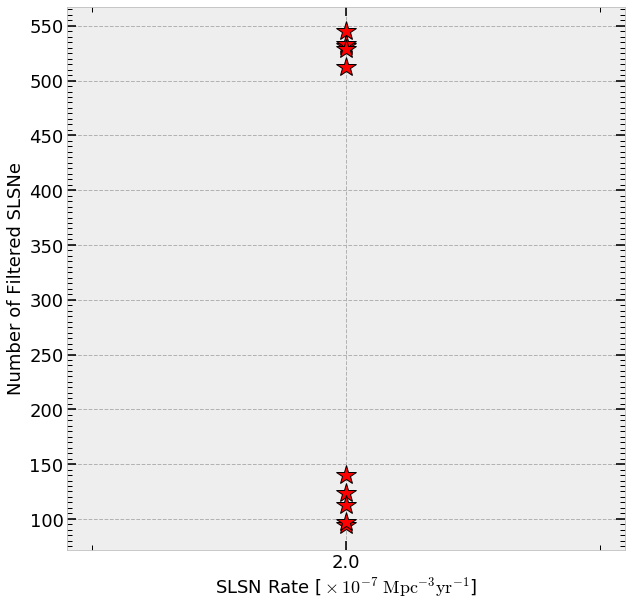

In [18]:
# ------------------------------------------------------------------------------------------------------------------- #
fig6 = plt.figure(figsize=(10, 10))
ax6 = fig6.add_subplot(111)

data_df = pd.read_csv(os.path.join(DIR_OUTPUT, 'LogSim_ZTF.dat'), sep='\s+', comment='#')

ax6.plot(data_df['Rate'], data_df['FilteredLCs'], ls='', mfc='r', c='k', marker='*', ms=20, label='_nolegend_')

set_plotparams(ax6, xticks=(0.5, 0.1), yticks=(50, 5), fs=18)
ax6.set_xlabel(r"SLSN Rate [$\rm \times 10^{-7}\ Mpc^{-3} yr^{-1}$]", fontsize=18)
ax6.set_ylabel('Number of Filtered SLSNe', fontsize=18)

fig6.savefig('PLOT_FilteredDetectionDistribution_{0}_{1}_{2}.pdf'.format(runmodel, zrange[0], zrange[1]),
             format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig6)
# ------------------------------------------------------------------------------------------------------------------- #

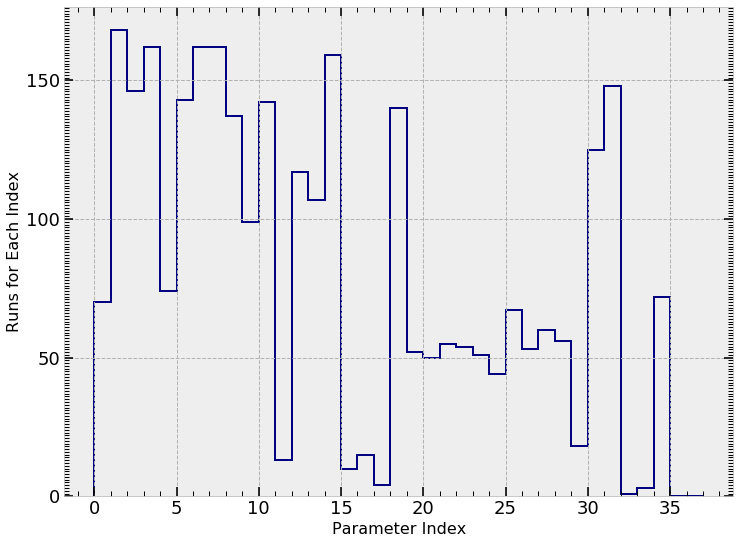

In [19]:
data = pd.read_csv(os.path.join(DIR_HOME, 'notebooks/LogSim_Indexes.dat'), sep='\s+', names=['run', 'idx'])
# print (data)
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

# ax.plot(data['idx'], data['run'])
ax.hist(data['idx'], lw=2, ls='-', histtype='step', color='navy', range=(0, 37), bins=37, label='Detected')
set_plotparams(ax, xticks=(5, 1), yticks=(50, 1), fs=18)

ax.set_ylabel('Runs for Each Index', fontsize=16)
ax.set_xlabel('Parameter Index', fontsize=16)

plt.show()
plt.close(fig)